In [147]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


EDA to prediction
1. EDA - Exploratory Data Analysis
1.1 Загрузить датасет, очистить
1.2 Подготовка признаков
1.3 Взаимосвязь
- как 1 признак (х1, х2, …) влияет на цель
1.4 Feature engineering (из существующих признаков генерируем свои)
- генерируем минимум 3 признака
1.5 Выводы
- данная переменная влияет на признак так-то 
- обосновать какие переменные берем, какие нет, почему


In [148]:
# Мы имеем два DF, один с статистикой аниме
df = pd.read_csv('./data/raw/anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [149]:
# Второй с статистикой пользоваотелей [кто, что, и как оценил]
df_users = pd.read_csv('./data/raw/rating.csv')
df_users.head()
# print(df['episodes'].unique())

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,355,-1


In [150]:

'''
Users = 73_516     and    Titles = 12_294
- anime_id - уникальный идентификатор myanimelist.net, идентифицирующий аниме.
- name - полное название аниме.
- genre - список жанров для данного аниме, разделенный запятыми.
- type - фильм, ТВ, OVA и т.д.
- episodes - сколько эпизодов в данном сериале. (1, если фильм).
- rating - средний рейтинг из 10 для этого аниме.
- members - количество членов сообщества, состоящих в данной "группе". - я так понимаю сколько человек посмотрело
'''
amount = len(df)
print('Amount of titles:', amount)
print('------------')
df.isnull().sum()
# проверяем общее количество нулевых значений
# Как мы можем это исправить?
# Жанр (ручной режим) - решать только в ручном режиме 
# # Тип (ручной режим) - если эпизоды = 1 -> фильм, эпизоды < 12 -> OVA, другие фильмы? 
# Рейтинг - можно найти аниме с одинаковыми жанрами и дать им общую среднюю оценку.

Amount of titles: 11433
------------


anime_id      0
name          0
genre        58
type         22
episodes      0
rating      210
members       0
dtype: int64

In [151]:
df['rating'].describe()

count    11223.000000
mean         6.476108
std          1.021547
min          1.670000
25%          5.885000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

In [152]:
df['genre'] = df['genre'].fillna('unknown')
df['type'] = df['type'].fillna(df['type'].mode()[0])
df['rating'] = df['rating'].fillna(df['rating'].mean())
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

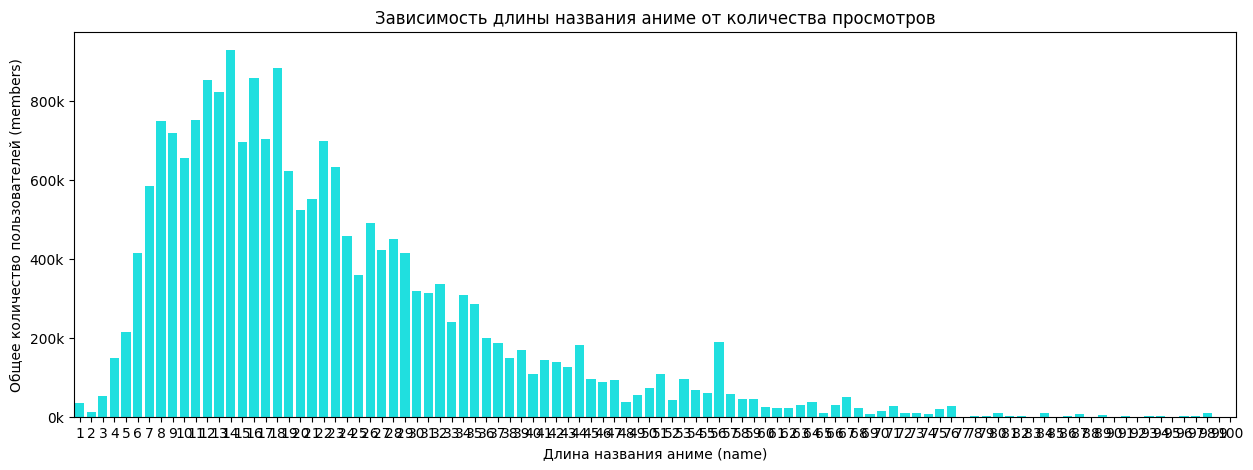

In [153]:
# Очевидно, нам нужно проверить, насколько длина заголовка влияет на аудиторию... пользователи, которые уже смотрели этот заголовок
df['len_of_title'] = df['name'].apply(len) # Это наш первый признак
# Разделим на уникальные группы, суммируем и сгруппируем с обновлением индекса  
df_grouped = df.groupby('len_of_title')['members'].sum().reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(x='len_of_title', y='members', data=df_grouped, color='cyan')

plt.xlabel('Длина названия аниме (name)')
plt.ylabel('Общее количество пользователей (members)')
plt.title('Зависимость длины названия аниме от количества просмотров')

# Для нашего удобства
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1e4)}k')
plt.gca().yaxis.set_major_formatter(formatter) # gca - get current axis   yaxis - turn to the object Y-label 

plt.show()

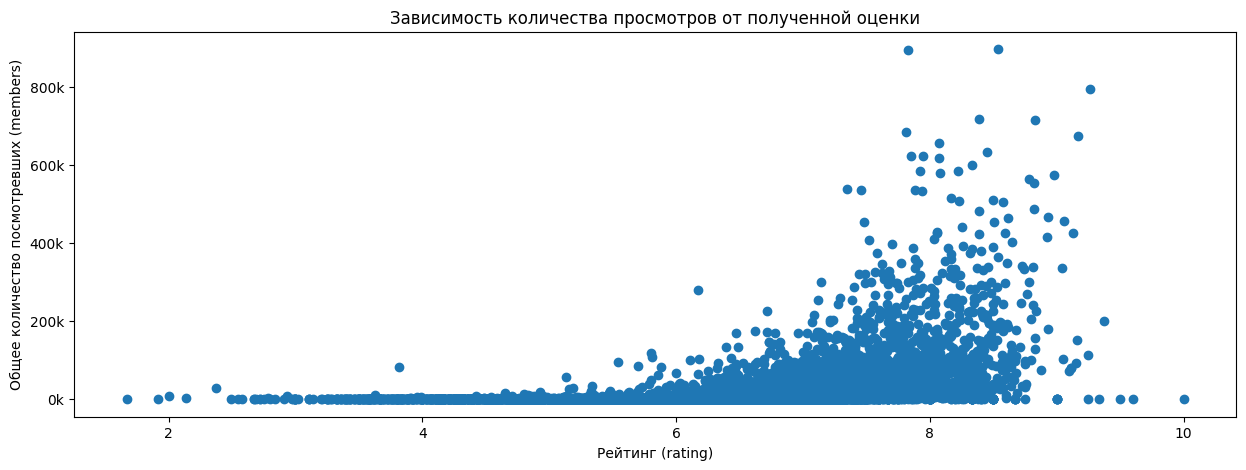

In [154]:
df_grouped = df.groupby('members')['rating'].sum().reset_index()

plt.figure(figsize=(15, 5))
plt.scatter(df['rating'], df['members'])

plt.xlabel('Рейтинг (rating)')
plt.ylabel('Общее количество посмотревших (members)')
plt.title('Зависимость количества просмотров от полученной оценки')

# Для нашего удобства
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1e3)}k')
plt.gca().yaxis.set_major_formatter(formatter) # gca - get current axis   yaxis - turn to the object Y-label 
    
plt.show()

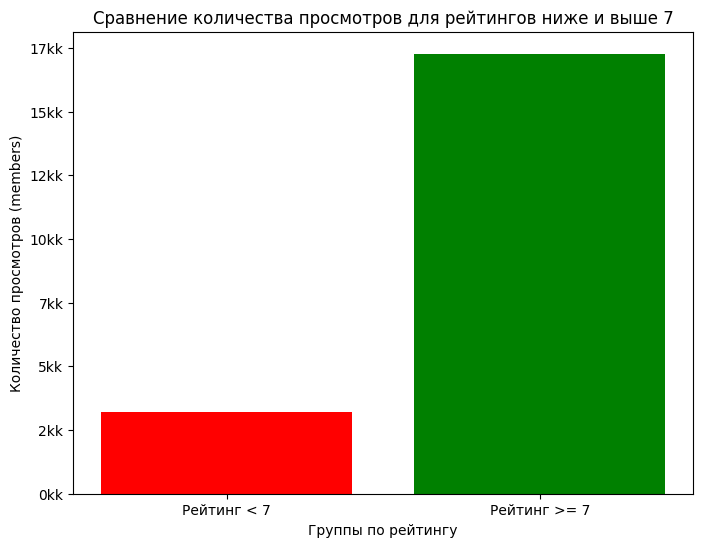

In [155]:
# Мы можем наблюдать восходящий тренд... следовательно, мы можем работать с этими данными
# Сначала мы можем разделить нашу оценку на 7 баллов меньше и на 7 баллов больше (на мой взгляд).
# Построим график зависимости общих просмотров от рейтинга

data_below_six_point = df[df['rating'] < 7]['members'].sum()
data_above_six_point = df[df['rating'] >= 7]['members'].sum()
rating_groups = ['Рейтинг < 7', 'Рейтинг >= 7']
members_counts = [data_below_six_point, data_above_six_point]

plt.figure(figsize=(8, 6))
plt.bar(rating_groups, members_counts, color=['red', 'green'])
plt.xlabel('Группы по рейтингу')
plt.ylabel('Количество просмотров (members)')
plt.title('Сравнение количества просмотров для рейтингов ниже и выше 7')
#plt.grid()

# Для нашего удобства
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1e7)}kk')
plt.gca().yaxis.set_major_formatter(formatter) # gca - get current axis   yaxis - turn to the object Y-label 
plt.show()

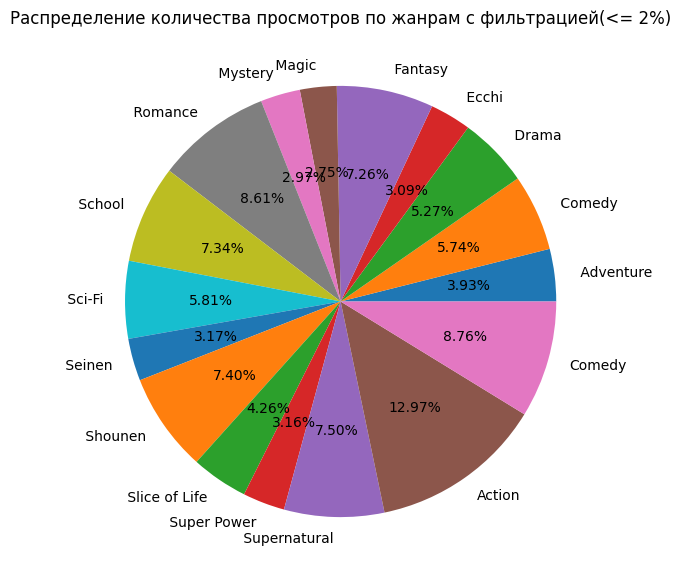

In [156]:
# Поранализуем жанры и постороим зависимость всех жанров от среднего рейтинга всех аниме
# Аналогично с количеством просмотров
df_genres = df.copy()
df_genres['genre'] = df_genres['genre'].str.split(',')
df_genres = df_genres.explode('genre') # разворачивает каждый список жанров в отдельные строки, так что каждый жанр теперь имеет свою строку

genre_members = df_genres.groupby('genre')['members'].sum()
                                                               # иначе не работает, так как сумма должна быть = 1, для pie chart
genre_members_normalized = genre_members / genre_members.sum() # простым языком, мы определяем вес каждого уникального жанра
                                                                                    # Фильтруем жанры, которые составляют менее 2% от общего объема
genre_members_filtered = genre_members_normalized[genre_members_normalized >= 0.02] # приколы пандаса, все true попадают, остальные мимо

plt.figure(figsize=(7, 7))

#plt.subplot(1, 2, 1)
plt.pie(genre_members_filtered, labels=genre_members_filtered.index, autopct='%1.2f%%')
plt.title('Распределение количества просмотров по жанрам с фильтрацией(<= 2%)')

#plt.subplot(1, 2, 2)
#plt.pie(genre_members_normalized, labels=genre_members_normalized.index, autopct='%1.2f%%')
#plt.title('Распределение количества просмотров по жанрам без фильтрации')
#plt.subplots_adjust(hspace=0.8, wspace=0.8)  # регулировка пространтсва

plt.show()

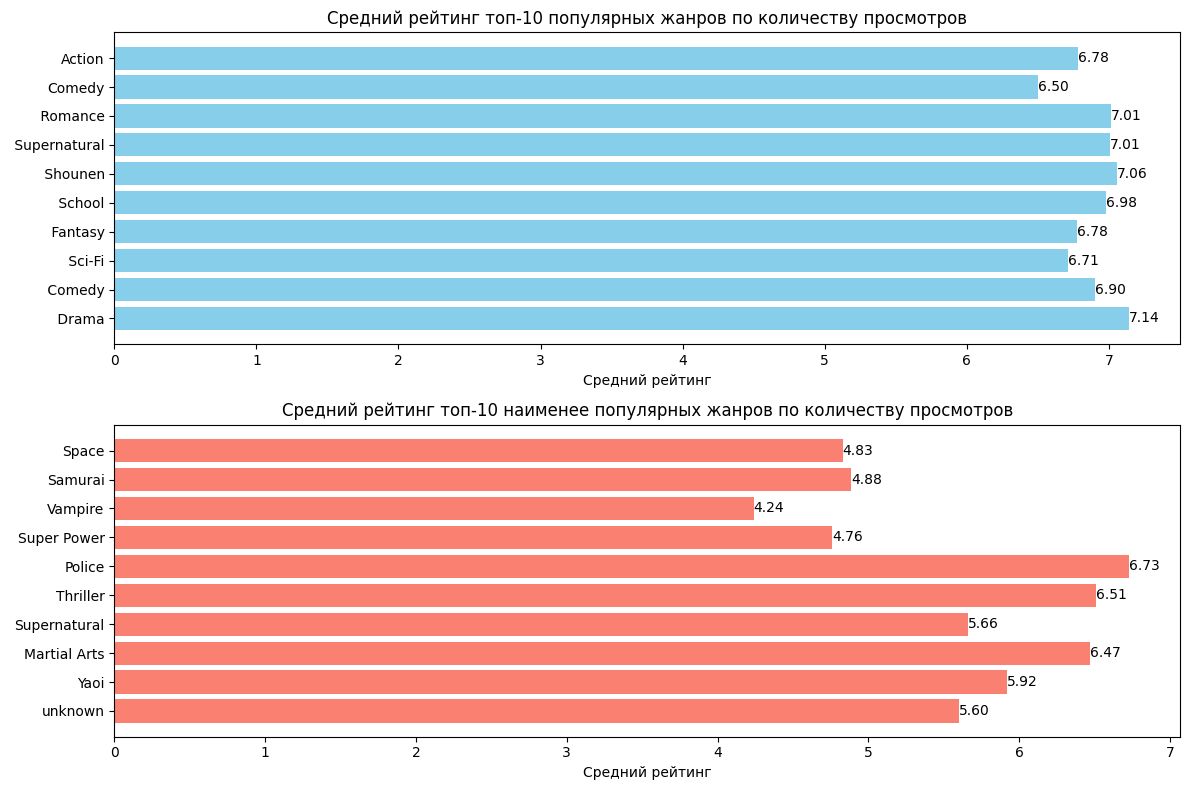

In [157]:
# Найдем средний рейтинг 10 популярных жанров и 10 наименее популярных жанров 
df_genres = df.copy()
df_genres['genre'] = df_genres['genre'].str.split(',')
df_genres = df_genres.explode('genre').reset_index(drop=True)

genre_rating = df_genres.groupby('genre')['rating'].mean()
genre_members = df_genres.groupby('genre')['members'].sum()

top_genres_high_views = genre_members.nlargest(10).index
top_genres_low_views = genre_members.nsmallest(10).index

top_genres_high_views_rating = genre_rating[top_genres_high_views]
top_genres_low_views_rating = genre_rating[top_genres_low_views]

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.barh(top_genres_high_views_rating.index, top_genres_high_views_rating.values, color="skyblue")
plt.xlabel('Средний рейтинг')
plt.title('Средний рейтинг топ-10 популярных жанров по количеству просмотров')
plt.gca().invert_yaxis()
for index, value in enumerate(top_genres_high_views_rating.values):
    plt.text(value, index, f'{value:.2f}', va='center')  # Аннотация значений

plt.subplot(2, 1, 2)
plt.barh(top_genres_low_views_rating.index, top_genres_low_views_rating.values, color="salmon")
plt.xlabel('Средний рейтинг')
plt.title('Средний рейтинг топ-10 наименее популярных жанров по количеству просмотров')
plt.gca().invert_yaxis()
for index, value in enumerate(top_genres_low_views_rating.values):
    plt.text(value, index, f'{value:.2f}', va='center')  # Аннотация значений

plt.tight_layout() # вроде удобная штука
plt.show()
# Видим, что жанры имеющие наибольшее количество просмотров имееют меньший разброс рейтинга 7±0.2,
# а наименее популярные жанры имеют огромный разброс и меньшую количественную оценку, т.к. являются специфичным жанром
# Можем сделать вывод, что от количество просмотров зависит оценка

In [158]:
# Признаки - среднее количество просмотров жанра и средняя оценка жанра
# Учтем, что жанров может быть несколько
df_genres = df.copy()
df_genres['genre'] = df_genres['genre'].str.split(',')
df_genres = df_genres.explode('genre').reset_index(drop=True)

genre_rating = df_genres.groupby('genre')['rating'].mean()
genre_members = df_genres.groupby('genre')['members'].mean()
print(genre_members.head())

def avg_genre_rating(genres):
    # Для каждого жанра получаем рейтинг из genre_rating
    genre_ratings = genre_rating[genres]  # выбираем средний рейтинг по жанрам
    return genre_ratings.mean()

def avg_members_genre(genres):
    genre_members_ = genre_members[genres]  
    return genre_members_.mean()

df['avg_rating_genre'] = df_genres['genre'].apply(lambda genres: avg_genre_rating(genres))
df['avg_members_genre'] = df_genres['genre'].apply(lambda genres: avg_members_genre(genres))
# Суммируем все жанры и находим среднее
# df.head()

genre
Adventure    32557.998797
Cars         12530.705882
Comedy       29175.914328
Dementia     15844.387097
Demons       42323.272727
Name: members, dtype: float64


In [159]:
df.loc[df['name'] == 'Naruto'].head(30)

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre
775,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,6,7.012914,46778.614353


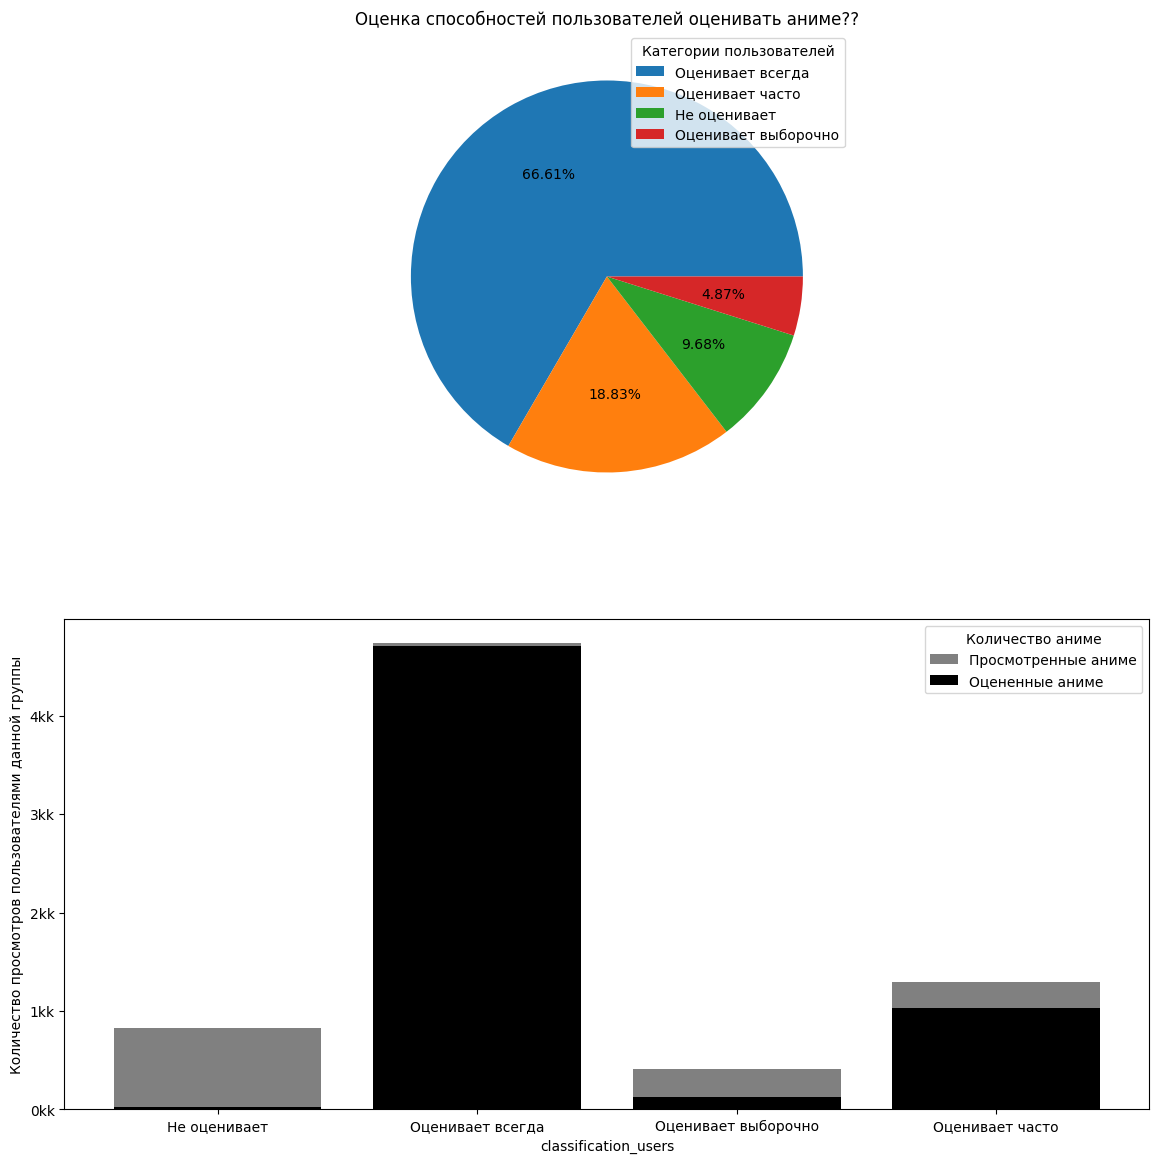

In [160]:
# Найдем %процент% пользователей кто оценивает аниме
# Предположим, если пользователь оценил более 85%~ просмотренных аниме, то он оценивает -> в будущем можно взять средний рейтинг
#              если пользователь оценил от 50 - 85%~ просмотренных аниме, то он переодично оценивает, либо избегает плохих оценок -> можно приравнять все недостающие оценки до ~5б
#              если пользователь оценил от 15 - 50%~ просмотренных аниме, то он оценивает выборочно -> в будущем не брать в статистику, данные могут быть не корректны
#              если пользователь оценил менее 15%~ -> не оценивает -> не брать в статистику

df_ratings = df_users.copy()

df_ratings['rated'] = df_ratings['rating'] != -1  # True для оцененных, False для неоцененных
df_ratings['rating'] = df_ratings['rating'].replace(-1, float('nan'))  # Заменим -1 на NaN для подсчета среднего

# Группируем данные по user_id для подсчета просмотров и оценок
user_stats = df_ratings.groupby('user_id').agg(
    total_watched=('anime_id', 'count'),          # Общее количество просмотренных аниме
    total_rated=('rated', 'sum')                  # Количество оцененных аниме (True считается как 1) для этого и заменяли на NaN
).reset_index()

user_stats['rating_percentage'] = (user_stats['total_rated'] / user_stats['total_watched']) * 100

# Классифицируем пользователей в зависимости от процента оценок
def classify_user(row):
    if row['rating_percentage'] > 95:
        return 'Оценивает всегда'
    elif 50 <= row['rating_percentage'] <= 95:
        return 'Оценивает часто'
    elif 15 <= row['rating_percentage'] < 50:
        return 'Оценивает выборочно'
    else:
        return 'Не оценивает'

user_stats['classification'] = user_stats.apply(classify_user, axis=1) # axis=1 - строки, axis=0 - столбцы
classification_counts = user_stats['classification'].value_counts()

classification_grouped = user_stats.groupby('classification').agg(
    total_watched=('total_watched', 'sum'),
    total_rated=('total_rated', 'sum')
).reset_index()

plt.figure(figsize=(14, 14))
plt.subplot(2,1,1)
plt.pie(classification_counts, autopct='%1.2f%%')
plt.title('Оценка способностей пользователей оценивать аниме??')
plt.legend(classification_counts.index, title='Категории пользователей', loc='upper right', fontsize=10)

anime_ = ['Просмотренные аниме', 'Оцененные аниме']

plt.subplot(2,1,2)
plt.bar(classification_grouped['classification'], classification_grouped['total_watched'], color='grey')
plt.bar(classification_grouped['classification'], classification_grouped['total_rated'], color='black')
plt.xlabel('classification_users')
plt.ylabel('Количество просмотров пользователями данной группы')
plt.legend(anime_, title='Количество аниме', loc='upper right', fontsize=10)

formatter = FuncFormatter(lambda x, pos: f'{int(x / 1e6)}kk')
plt.gca().yaxis.set_major_formatter(formatter) # gca - get current axis   yaxis - turn to the object Y-label 

plt.show()

# дополнительные признаки, дополним df
df_users.head()
df_users = pd.merge(df_users, user_stats[['user_id', 'classification', 'rating_percentage']], on='user_id', how='left')

In [161]:
# Переформируем признак classicification_users -> user_activity - будет показывать метрику, которая означает 
# какое количество людей оценило аниме из просмотревших
df_users_cleaned = df_users.copy()
df_users_cleaned.loc[df_users_cleaned['rating'] == -1, 'rating'] = np.nan
df_users_grouped = df_users_cleaned.groupby('anime_id').agg(
    rated_count=('rating', 'count'), # Сколько оценило (исключая NaN)
    total_viewers=('rating', 'size') # Сколько всего посмотревших (включая NaN)
).reset_index()
df['user_activity'] = df_users_grouped['rated_count'] / df_users_grouped['total_viewers'] * 100 # это будет процентной метрикой
df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,user_activity
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,14,6.794607,17996.367679,86.637002
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,32,7.012914,46778.614353,83.570986
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,8,6.976727,45968.970909,84.633363
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,11,7.009219,54872.494155,82.326531
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,13,6.779782,33631.420934,73.947368


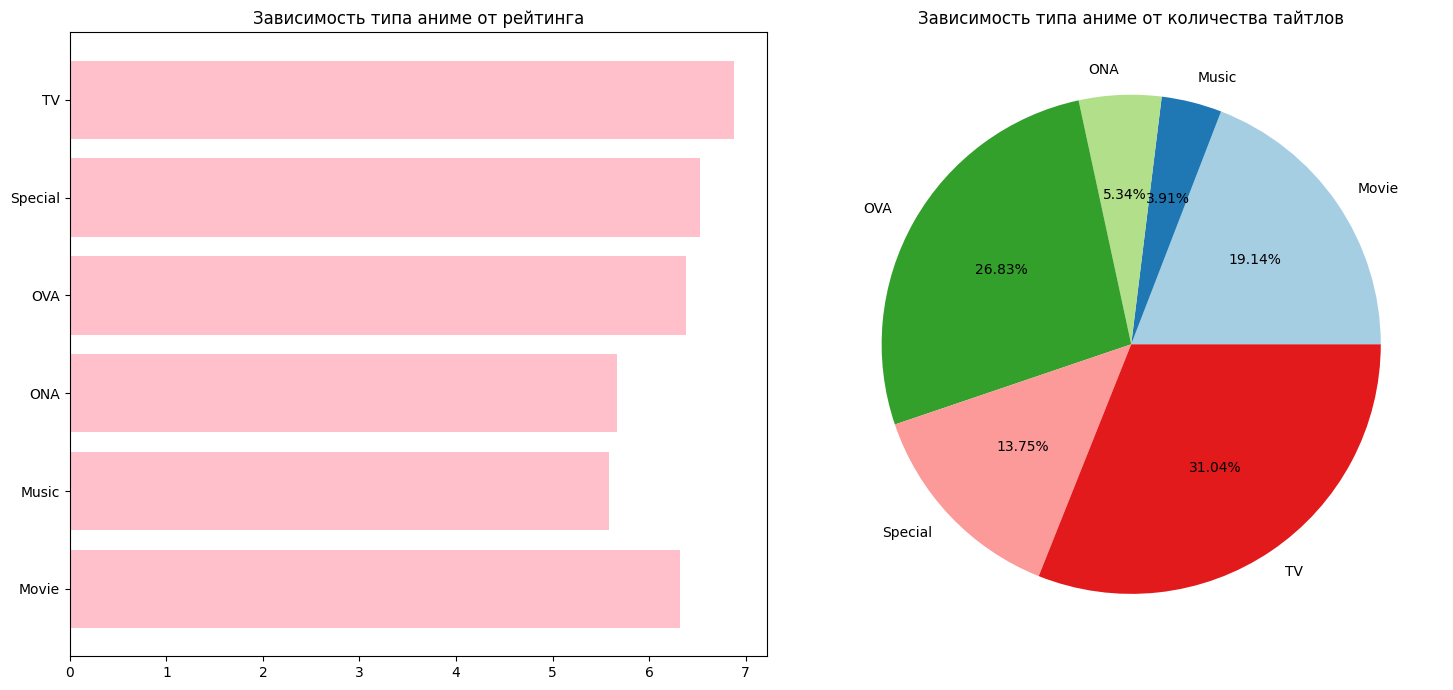

In [162]:
df_grouped = df.groupby('type').agg({'rating': 'mean', 'anime_id': 'count'}).reset_index()

plt.figure(figsize=(15, 7))

# Средний рейтинг по типам аниме
plt.subplot(1, 2, 1)
plt.barh(df_grouped['type'], df_grouped['rating'], color="pink")
plt.title('Зависимость типа аниме от рейтинга')

# Количество аниме по типам
plt.subplot(1, 2, 2)
plt.pie(df_grouped['anime_id'], labels=df_grouped['type'], autopct='%1.2f%%', colors=plt.cm.Paired.colors)
plt.title('Зависимость типа аниме от количества тайтлов')

plt.tight_layout()  # регулировка расположения графиков

plt.show()

# Добавим второй признак!
# Чем больше аниме в категории, тем более разнообразные вкусы и мнения среди зрителей. Следовательно отследить средний
# рейтинг у непопулярных типов аниме(music, ona) легче предсказать? или нет? 
df['anime_count_by_type'] = df['type'].map(df_grouped.set_index('type')['anime_id'])
# Также хочу добавить "Соотношение среднего рейтинга аниме[type] и количества аниме"
# По идее... Если категория имеет высокое соотношение рейтинга и количества аниме,
# это может означать, что рейтинг в этой категории предсказуем и стабильнее
df['avg_rating_by_type'] = df['type'].map(df_grouped.set_index('type')['rating']) # Средний рейтинг для галочки тут
# 3ий признак! Задидим метрику в таком виде...
df['avg_type_rating_to_anime_count'] = df['avg_rating_by_type'] / df['anime_count_by_type']


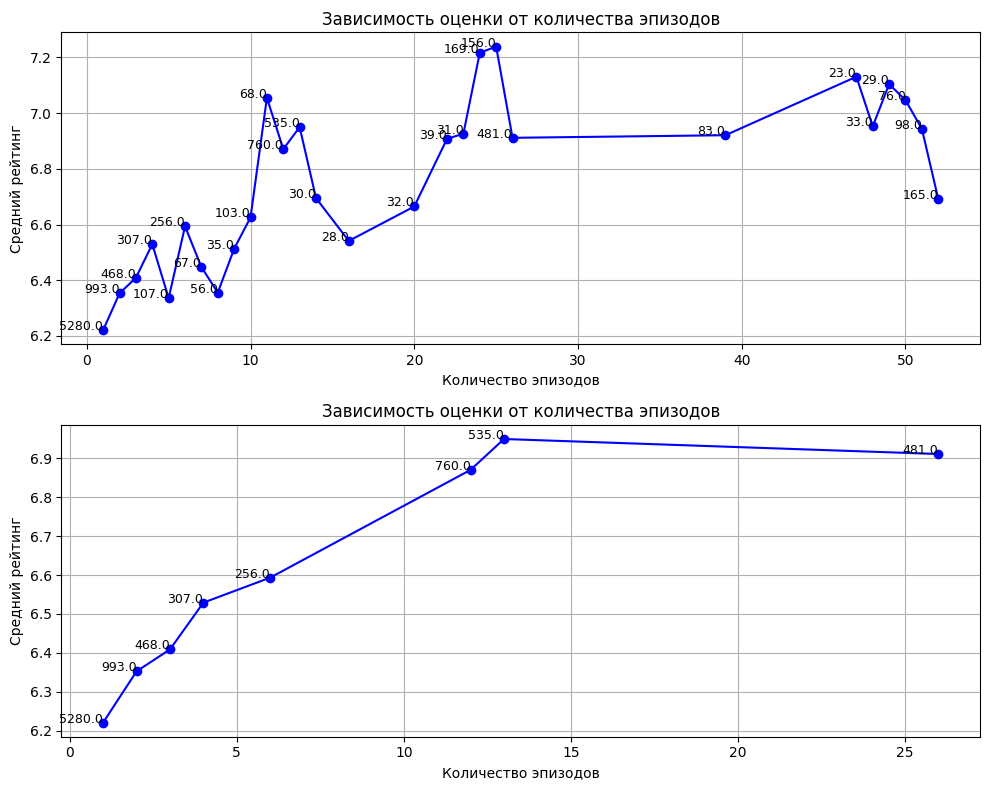

In [163]:
# Проверим как количество эпизодов влияет на среднюю оценку
df_ep = df['episodes'].unique()
count_of_unknown = (df_ep == 'Unknown').sum()
# print(count_of_unknown) - это единичный случай - не берем


df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')  # в числовой формат -> игнорируем ошибки (Unknown -> NaN)
df_episodes = df.dropna(subset=['episodes']).copy() # а тут удалим их
                                                    # subset - указывает на удаление в конкретном столбце
episode_counts = df_episodes['episodes'].value_counts()

df_episodes = df_episodes[df_episodes['episodes'].isin(episode_counts[episode_counts > 20].index)] # фильтруем данные
                                                                                            
df_grouped = df_episodes.groupby('episodes').agg(
    rating_mean=('rating', 'mean'),
    count=('rating', 'size')
).reset_index()

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(df_grouped['episodes'], df_grouped['rating_mean'], color='blue', marker='o', linestyle='-')
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний рейтинг')        
plt.title('Зависимость оценки от количества эпизодов')
plt.grid(True)

for i, row in df_grouped.iterrows():
    plt.text(row['episodes'], row['rating_mean'], f"{row['count']}", ha='right', fontsize=9)

df_episodes = df_episodes[df_episodes['episodes'].isin(episode_counts[episode_counts > 200].index)] # фильтруем данные
                                                                                            
df_grouped = df_episodes.groupby('episodes').agg(
    rating_mean=('rating', 'mean'),
    count=('rating', 'size')
).reset_index()

plt.subplot(2,1,2)
plt.plot(df_grouped['episodes'], df_grouped['rating_mean'], color='blue', marker='o', linestyle='-')
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний рейтинг')        
plt.title('Зависимость оценки от количества эпизодов')
plt.grid(True)

for i, row in df_grouped.iterrows():
    plt.text(row['episodes'], row['rating_mean'], f"{row['count']}", ha='right', fontsize=9)

plt.tight_layout()
plt.show()
# График ничего не даёт?
# Второй график особо не репрезентабелен, относительно первого

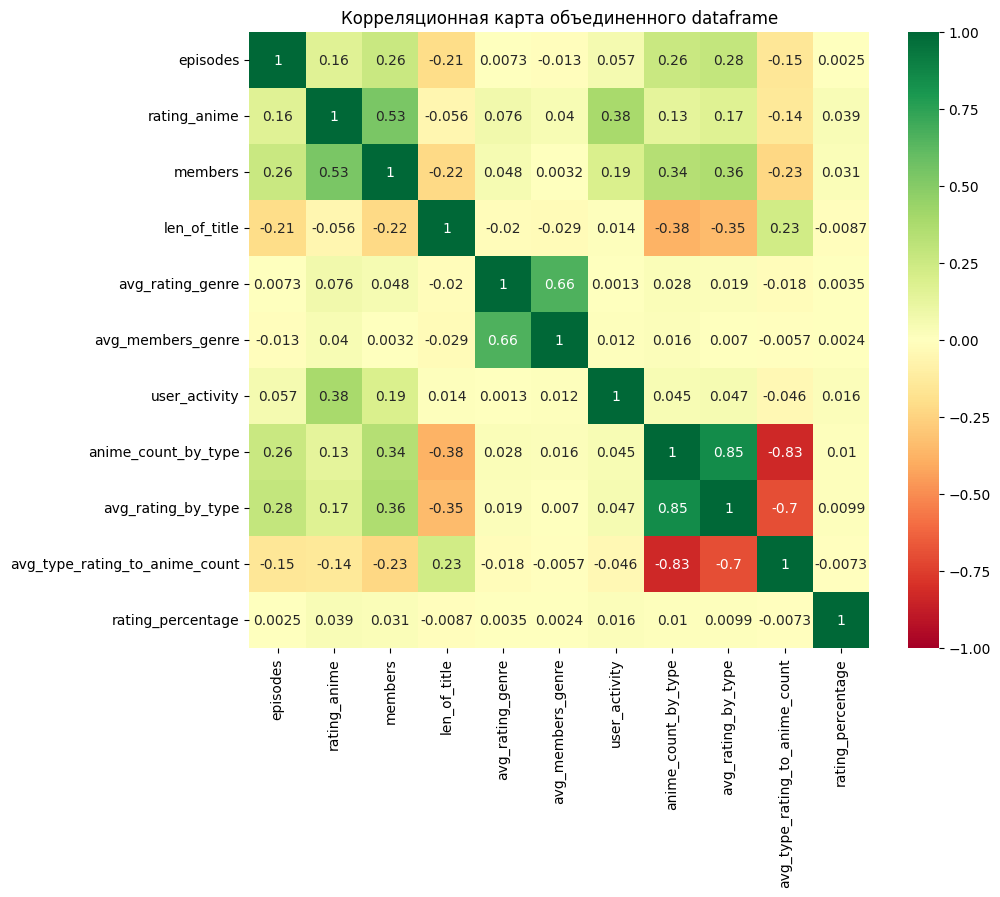

In [164]:
df_merged = pd.merge(df, df_users, on='anime_id', suffixes = ('_anime', '_user'))

# Не забыть дропнуть колонки лишние
df_merged_cleaned = df_merged.drop(columns=['anime_id','user_id','name','genre','type','rating_user'])
df_numeric = df_merged_cleaned.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))  # размер графика
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Корреляционная карта объединенного dataframe")
plt.show()

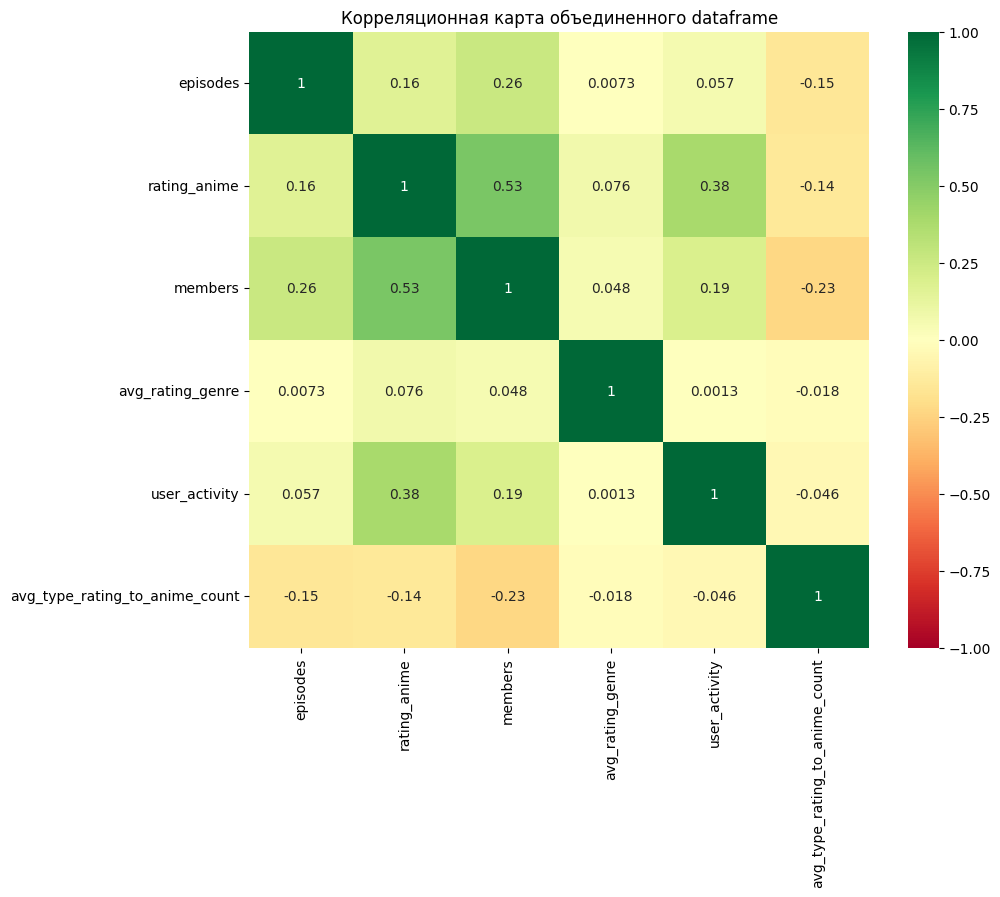

In [165]:
df_merged = pd.merge(df, df_users, on='anime_id', suffixes = ('_anime', '_user'))

# Не забыть дропнуть колонки лишние
df_merged_cleaned = df_merged.drop(columns=['anime_id','user_id','name','genre','type','rating_user', 'avg_rating_by_type', 'anime_count_by_type', 'rating_percentage', 'len_of_title', 'avg_members_genre'])
df_numeric = df_merged_cleaned.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))  # размер графика
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Корреляционная карта объединенного dataframe")
plt.show()

In [166]:
'''
Вывод: 
    Создана своя собственная EDA, исследованы некоторые зависимости признаков из дата на целевую переменную(rating), сформированные свои признаки(представлены ниже).
Сформированные признаки(краткая аннотация):
1. df['len_of_title'] - длина аниме
2. df['avg_type_rating_to_anime_count'] - отношение среднего рейтинга по типу аниме и количество такого типа аниме в датасете
3. df['user_activity'] - как часто пользователи оценивают аниме после просмотра(активность пользователя в процентах)
4. df['avg_members_genre'] - среднее количество просмотров, если их несколько, то берем mean()
5. df['avg_rating_genre'] - средний рейтинг жанра, если их несколько, то берем mean()
    Из тепловой карты(корреляционной матрицы) увидим, что просмотры['members'] это наиболее коррелирующая с целевой переменная, следовательно, влияние на неё сильно сказывается на целевой переменной. Поэтому, если просмотры коррелируют от какого-либо признака, то это значит, что и целевая зависит от неё.
   Как эти признаки влияют на целевую переменную:
1. Длина аниме влияет на просмотры, а просмотры влияют на рейтинг
2. Рейтинг распределяется почти равномерно. Но! Необхдимо учитывать, что существуют специфичные типы(Music), количество которых кратно меньше, чем более популярных. Для этого и создана эта метрика.
3. Активность пользователя поможет понять насколько "правильный"/"верный" рейтинг, аниме может быть как и не до оценено или переоценно, из-за завышенной оценки и малом %те оценивших
4. и 5. После исследования влияния просмотров и рейтинга на жанры (соответствующие графики построены) выбираемые пользователями, сделан вывод о том, что по аниме можно судить исходя из жанров, которые оно содержит.
    Очевидно, что это только малая часть признаков, выделенных мной. Если будут проблемы при построении модели линейной регрессии, то с помощью своих исследований, проведенных выше, я без проблем, могу ввести дополнительные признаки.
   Поставленные задачи выполненны, работу можно считать выполенной
'''

'\nВывод: \n    Создана своя собственная EDA, исследованы некоторые зависимости признаков из дата на целевую переменную(rating), сформированные свои признаки(представлены ниже).\nСформированные признаки(краткая аннотация):\n1. df[\'len_of_title\'] - длина аниме\n2. df[\'avg_type_rating_to_anime_count\'] - отношение среднего рейтинга по типу аниме и количество такого типа аниме в датасете\n3. df[\'user_activity\'] - как часто пользователи оценивают аниме после просмотра(активность пользователя в процентах)\n4. df[\'avg_members_genre\'] - среднее количество просмотров, если их несколько, то берем mean()\n5. df[\'avg_rating_genre\'] - средний рейтинг жанра, если их несколько, то берем mean()\n    Из тепловой карты(корреляционной матрицы) увидим, что просмотры[\'members\'] это наиболее коррелирующая с целевой переменная, следовательно, влияние на неё сильно сказывается на целевой переменной. Поэтому, если просмотры коррелируют от какого-либо признака, то это значит, что и целевая зависит о

In [167]:
df.loc[df['name'] == 'Naruto'].head(30)

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,user_activity,anime_count_by_type,avg_rating_by_type,avg_type_rating_to_anime_count
775,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,6,7.012914,46778.614353,80.348653,3549,6.881314,0.001939


In [168]:
df.isnull().sum()

anime_id                            0
name                                0
genre                               0
type                                0
episodes                          316
rating                              0
members                             0
len_of_title                        0
avg_rating_genre                    0
avg_members_genre                   0
user_activity                     312
anime_count_by_type                 0
avg_rating_by_type                  0
avg_type_rating_to_anime_count      0
dtype: int64

In [169]:
# Появилась проблема, в df появились anime_id которых нету в df_users, но это в принципе не важно, проигнорируем их
missing_anime_ids = set(df['anime_id']) - set(df_users['anime_id'])
print("Отсутствующие anime_id в df_users_grouped:", len(missing_anime_ids))
df['user_activity'] = df['user_activity'].fillna(0) # Нет оценок - нет user_activity
df.isnull().sum()

Отсутствующие anime_id в df_users_grouped: 1078


anime_id                            0
name                                0
genre                               0
type                                0
episodes                          316
rating                              0
members                             0
len_of_title                        0
avg_rating_genre                    0
avg_members_genre                   0
user_activity                       0
anime_count_by_type                 0
avg_rating_by_type                  0
avg_type_rating_to_anime_count      0
dtype: int64

In [170]:
df.dtypes

anime_id                            int64
name                               object
genre                              object
type                               object
episodes                          float64
rating                            float64
members                             int64
len_of_title                        int64
avg_rating_genre                  float64
avg_members_genre                 float64
user_activity                     float64
anime_count_by_type                 int64
avg_rating_by_type                float64
avg_type_rating_to_anime_count    float64
dtype: object

In [171]:
# Появились проблемы с episodes почему он OBJECT? необходимо исправить, нельзя терять этот признак
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df = df.dropna(subset=['episodes']) # Либо заменять либо дропать... будем держаться подальше от греха

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на признаки (X) и целевую переменную (y)
x = df.drop(columns=["rating", "name", "genre", "anime_id", "type", "avg_type_rating_to_anime_count"])  # rating — целевая переменная
y = df["rating"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # 42 - забавный сид :-3

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test) # Прогоняем по тестам

mse = mean_squared_error(y_test, y_pred) # Оценим качество нашей милой модели с помощбью поиска квадратичных ошибок
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Коэффициенты модели:", model.coef_)
print("Свободный член:", model.intercept_)

Mean Squared Error (MSE): 0.7080743720316136
R-squared (R2): 0.3186602713291976
Коэффициенты модели: [1.94849701e-04 5.82744372e-06 1.11427961e-02 2.54496278e-01
 2.45948932e-07 8.68397696e-03 7.59111783e-05 6.06492655e-01]
Свободный член: -0.3263266396870552


Видим, что MSE равно ~0.65, это достаточно много для нашей модели, так как рейтинг находится в пределах 1-10.
R-squared (R2) - показывает насколько эффективно модель предсказывает результаты -> 37% - это плохая метрика.
Коэффициенты модели - достаточно различны, что может влиять на обучение и способствовать появлению являния переобучения.
Свободный член ??? зачем эта метрика?

Нужно исправить это, как? Пока что можно предположить, что коэффициент корреляции признаков мал, следовательно, из-за этого невозможно применять линейную регрессию -> попробуем убрать лишние признаки, исследовать выбросы и удалить их.

Мультиколлинеарность признаков не наблюдается?

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на признаки (X) и целевую переменную (y)
x = df[["members", "user_activity", "avg_rating_genre", "episodes", "avg_type_rating_to_anime_count"]] 
y = df["rating"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # 42 - забавный сид :-3

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test) # Прогоняем по тестам

mse = mean_squared_error(y_test, y_pred) # Оценим качество нашей милой модели с помощбью поиска квадратичных ошибок
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Коэффициенты модели:", model.coef_)
print("Свободный член:", model.intercept_)

Mean Squared Error (MSE): 0.749560820715245
R-squared (R2): 0.27874021941640426
Коэффициенты модели: [ 6.31235958e-06  9.18479930e-03  2.65011439e-01  7.71983200e-04
 -9.13943204e+01]
Свободный член: 4.267165532697219


Получили неудовлетворительные результаты для модели, выделим новые признаки и построим кластеры

In [174]:
df_genres = df.copy()
df_genres['genre'] = df_genres['genre'].str.split(',')
df_genres = df_genres.explode('genre') # разворачивает каждый список жанров в отдельные строки, так что каждый жанр теперь имеет свою строку

genre_members = df_genres.groupby('genre')['members'].sum()
unique_genres_count = df_genres['genre'].nunique()

print(f"Количество уникальных жанров: {unique_genres_count}")

unique_genres_list = df_genres['genre'].unique().tolist()
print("Уникальные жанры (список):", unique_genres_list)

Количество уникальных жанров: 83
Уникальные жанры (список): ['Drama', ' Romance', ' School', ' Supernatural', 'Action', ' Adventure', ' Drama', ' Fantasy', ' Magic', ' Military', ' Shounen', ' Comedy', ' Historical', ' Parody', ' Samurai', ' Sci-Fi', 'Sci-Fi', ' Thriller', 'Comedy', ' Sports', ' Super Power', ' Space', ' Slice of Life', ' Mecha', 'Adventure', ' Music', ' Mystery', ' Seinen', 'Fantasy', ' Martial Arts', ' Vampire', ' Shoujo', ' Horror', ' Police', ' Psychological', 'Psychological', 'Mystery', ' Demons', 'Ecchi', 'Josei', 'Military', 'Romance', ' Shounen Ai', ' Game', ' Josei', 'Demons', 'Dementia', ' Ecchi', ' Harem', 'Music', 'Game', ' Cars', 'Mecha', 'Horror', 'School', ' Kids', 'Historical', ' Dementia', ' Shoujo Ai', 'Shounen', 'Cars', 'Shoujo', 'Magic', 'Harem', 'Martial Arts', 'Kids', 'Sports', 'Slice of Life', 'Seinen', 'unknown', 'Parody', 'Police', 'Thriller', 'Supernatural', 'Samurai', 'Super Power', 'Vampire', 'Space', 'Hentai', ' Yaoi', ' Hentai', ' Yuri', '

In [175]:
# Разделяем жанры и сохраняем их как список в одном столбце
df['genre'] = df['genre'].str.split(',')
df['genre'] = df['genre'].apply(lambda x: [genre.strip() for genre in x])  # Убираем лишние пробелы
df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,user_activity,anime_count_by_type,avg_rating_by_type,avg_type_rating_to_anime_count
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,14,6.794607,17996.367679,86.637002,2188,6.320060,0.002889
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,32,7.012914,46778.614353,83.570986,3549,6.881314,0.001939
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,8,6.976727,45968.970909,84.633363,3549,6.881314,0.001939
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,11,7.009219,54872.494155,82.326531,3549,6.881314,0.001939
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,13,6.779782,33631.420934,73.947368,3549,6.881314,0.001939


In [176]:
# Закодируем жанры - придется добавить 83 столбика, достаточно плохо! Поэтому объединим жанры по группам
genre_categories = {
    'Action/Adventure': ['Action', 'Adventure', 'Martial Arts', 'Samurai', 'Military'],
    'Fantasy/Supernatural': ['Fantasy', 'Magic', 'Supernatural', 'Demons', 'Vampire'],
    'Comedy': ['Comedy', 'Parody', 'Slice of Life'],
    'Drama/Romance': ['Drama', 'Romance', 'Josei', 'Shoujo', 'Shounen Ai'],
    'Science Fiction': ['Sci-Fi', 'Space', 'Mecha', 'Cars'],
    'Psychological/Thriller': ['Psychological', 'Thriller', 'Mystery', 'Dementia'],
    'Other/Uncategorized': ['Kids', 'Hentai', 'Yaoi', 'Yuri', 'Ecchi', 'unknown']
}

def map_genres_to_categories(genres):
    categories = {category: 0 for category in genre_categories}  # Все категории по умолчанию равны 0
    
    # Проходим по категориям и проверяем, попадают ли жанры в эти категории
    for category, genre_list in genre_categories.items():
        if any(genre in genres for genre in genre_list):  # Если хотя бы один жанр совпадает
            categories[category] = 1  # Присваиваем 1 для этой категории
    
    return categories

categories_df = df['genre'].apply(map_genres_to_categories)
categories_df = pd.DataFrame(categories_df.tolist(), index=df.index)
df = pd.concat([df, categories_df], axis=1)
df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,...,anime_count_by_type,avg_rating_by_type,avg_type_rating_to_anime_count,Action/Adventure,Fantasy/Supernatural,Comedy,Drama/Romance,Science Fiction,Psychological/Thriller,Other/Uncategorized
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,14,6.794607,17996.367679,...,2188,6.320060,0.002889,0,1,0,1,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,32,7.012914,46778.614353,...,3549,6.881314,0.001939,1,1,0,1,0,0,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,8,6.976727,45968.970909,...,3549,6.881314,0.001939,1,0,1,0,1,0,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,11,7.009219,54872.494155,...,3549,6.881314,0.001939,0,0,0,0,1,1,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,13,6.779782,33631.420934,...,3549,6.881314,0.001939,1,0,1,0,1,0,0


In [177]:
df_type = df.copy()

unique_type_count = df_type['type'].nunique()
print(f"Количество уникальных жанров: {unique_type_count}")

unique_type_list = df_type['type'].unique().tolist()
print("Уникальные жанры (список):", unique_type_list)

Количество уникальных жанров: 6
Уникальные жанры (список): ['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA']


In [178]:
unique_types = df['type'].unique()

# Бинаризация: создаем столбец для каждого уникального типа
for anime_type in unique_types:
    df[anime_type] = (df['type'] == anime_type).astype(int)

df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,...,Drama/Romance,Science Fiction,Psychological/Thriller,Other/Uncategorized,Movie,TV,OVA,Special,Music,ONA
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,14,6.794607,17996.367679,...,1,0,0,0,1,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,32,7.012914,46778.614353,...,1,0,0,0,0,1,0,0,0,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,8,6.976727,45968.970909,...,0,1,0,0,0,1,0,0,0,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,11,7.009219,54872.494155,...,0,1,1,0,0,1,0,0,0,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,13,6.779782,33631.420934,...,0,1,0,0,0,1,0,0,0,0


In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на признаки (X) и целевую переменную (y)
x = df.drop(columns=["rating", "name", "genre", "anime_id", "type", "avg_type_rating_to_anime_count", "avg_rating_by_type"])  # rating — целевая переменная
y = df["rating"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # 42 - забавный сид :-3

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test) # Прогоняем по тестам

mse = mean_squared_error(y_test, y_pred) # Оценим качество нашей милой модели с помощбью поиска квадратичных ошибок
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Коэффициенты модели:", model.coef_)
print("Свободный член:", model.intercept_)

Mean Squared Error (MSE): 0.659647711119823
R-squared (R2): 0.3652584950601353
Коэффициенты модели: [ 4.92008678e-04  5.19881089e-06  9.79632757e-03  2.37303427e-01
 -1.10376740e-07  7.72286516e-03  2.51085072e-04  2.23589129e-01
  9.94948530e-02  1.29688217e-01  3.87098586e-01  3.82147244e-02
 -2.74937151e-02 -1.45808024e-01 -5.18519502e-02 -1.09051107e-02
 -4.61071719e-02  2.38918677e-01  1.64521305e-02 -1.46506575e-01]
Свободный член: 3.1415420978324238


In [180]:

# Разделяем данные на признаки (X) и целевую переменную (y)
x = df.drop(columns=["rating", "name", "genre", "anime_id", "type", "avg_type_rating_to_anime_count"])  # rating — целевая переменная
y = df["rating"]

# Масштабируем данные
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Разделяем данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Применяем RFE для выбора лучших признаков
model = LinearRegression()
selector = RFE(model, n_features_to_select=10)  # Оставим 10 признаков
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)

# Обучаем модель
model.fit(x_train_selected, y_train)

# Прогнозирование
y_pred = model.predict(x_test_selected)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.6649759192668006
R-squared (R2): 0.36013146315987443


In [181]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Обучение модели RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_selected, y_train)

# Прогнозирование
y_pred_rf = rf_model.predict(x_test_selected)

# Оценка модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error (MSE):", mse_rf)
print("Random Forest R-squared (R2):", r2_rf)

Random Forest Mean Squared Error (MSE): 0.48791775139065674
Random Forest R-squared (R2): 0.5305044759742616


In [182]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,...,Drama/Romance,Science Fiction,Psychological/Thriller,Other/Uncategorized,Movie,TV,OVA,Special,Music,ONA
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,14,6.794607,17996.367679,...,1,0,0,0,1,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,32,7.012914,46778.614353,...,1,0,0,0,0,1,0,0,0,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,8,6.976727,45968.970909,...,0,1,0,0,0,1,0,0,0,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,11,7.009219,54872.494155,...,0,1,1,0,0,1,0,0,0,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,13,6.779782,33631.420934,...,0,1,0,0,0,1,0,0,0,0


In [183]:
# Продолжаем улучшать метрики
df_ = df.copy()
df_['rating_x_members'] = df_['rating'] * df_['members']
df['rating_per_million'] = (df['rating'] / df['members']) * 1e6

mean_episodes_by_type = df.groupby('type')['episodes'].transform('mean')
df['normalized_episodes'] = df['episodes'] / mean_episodes_by_type

df['rating_x_members_normalized'] = (df_['rating_x_members'] - df_['rating_x_members'].min()) / \
                                     (df_['rating_x_members'].max() - df_['rating_x_members'].min())
df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,...,Other/Uncategorized,Movie,TV,OVA,Special,Music,ONA,rating_per_million,normalized_episodes,rating_x_members_normalized
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,14,6.794607,17996.367679,...,0,1,0,0,0,0,0,46.702886,0.901031,0.245609
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,32,7.012914,46778.614353,...,0,0,1,0,0,0,0,11.667391,1.785012,0.960221
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,8,6.976727,45968.970909,...,0,0,1,0,0,0,0,80.954298,1.422432,0.138082
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,11,7.009219,54872.494155,...,0,0,1,0,0,0,0,13.613986,0.669380,0.807003
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,13,6.779782,33631.420934,...,0,0,1,0,0,0,0,60.555578,1.422432,0.181025


In [184]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Обучение модели RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_selected, y_train)

# Прогнозирование
y_pred_rf = rf_model.predict(x_test_selected)

# Оценка модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error (MSE):", mse_rf)
print("Random Forest R-squared (R2):", r2_rf)

Random Forest Mean Squared Error (MSE): 0.48791775139065674
Random Forest R-squared (R2): 0.5305044759742616


In [185]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,len_of_title,avg_rating_genre,avg_members_genre,...,Other/Uncategorized,Movie,TV,OVA,Special,Music,ONA,rating_per_million,normalized_episodes,rating_x_members_normalized
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,14,6.794607,17996.367679,...,0,1,0,0,0,0,0,46.702886,0.901031,0.245609
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,32,7.012914,46778.614353,...,0,0,1,0,0,0,0,11.667391,1.785012,0.960221
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,8,6.976727,45968.970909,...,0,0,1,0,0,0,0,80.954298,1.422432,0.138082
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,11,7.009219,54872.494155,...,0,0,1,0,0,0,0,13.613986,0.669380,0.807003
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,13,6.779782,33631.420934,...,0,0,1,0,0,0,0,60.555578,1.422432,0.181025


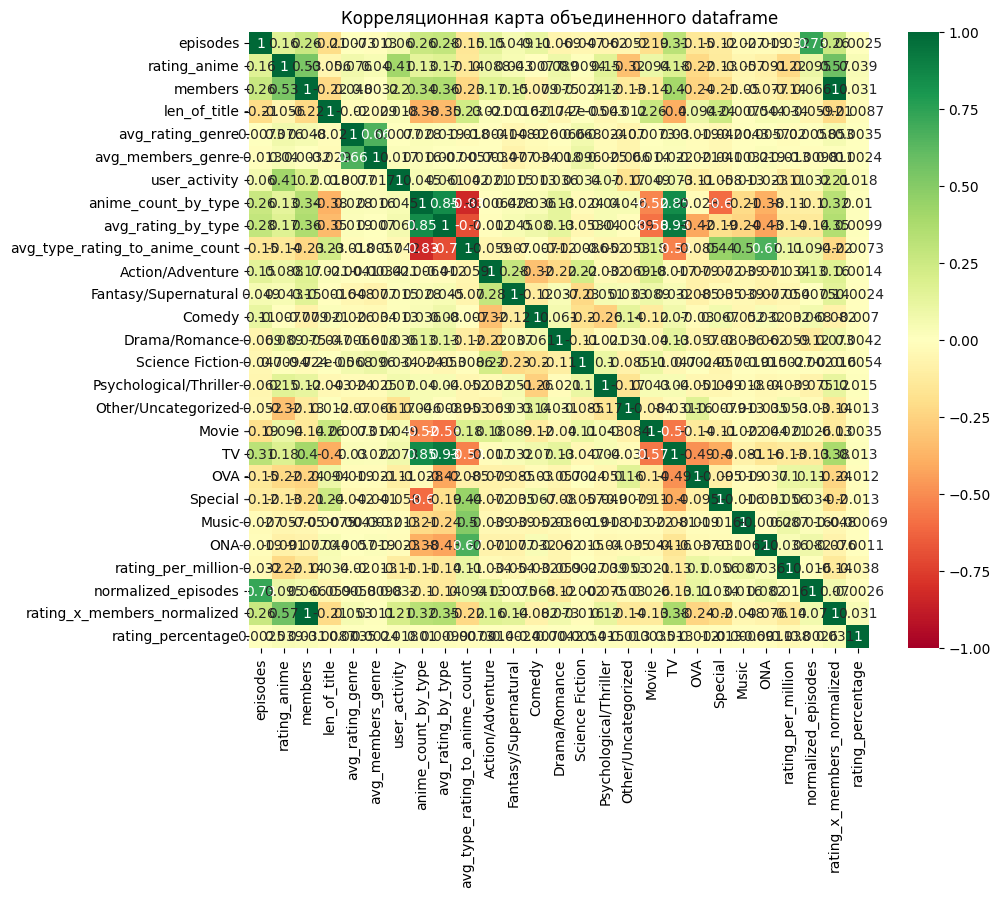

In [186]:
df_merged = pd.merge(df, df_users, on='anime_id', suffixes = ('_anime', '_user'))

# Не забыть дропнуть колонки лишние
df_merged_cleaned = df_merged.drop(columns=['anime_id','user_id','name','genre','type','rating_user'])
df_numeric = df_merged_cleaned.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))  # размер графика
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Корреляционная карта объединенного dataframe")
plt.show()
# ради интереса строю

In [187]:
# Пробуем логарифмировать 
df['log_members'] = np.log(df['members'] + 1)  # Добавляем 1, чтобы избежать log(0)
df['log_rating_per_million'] = np.log(df['rating_per_million'] + 1)

In [188]:
# Разделение данных на признаки (X) и целевую переменную (y)
x = df.drop(columns=["rating", "name", "genre", "anime_id", "type", "avg_type_rating_to_anime_count", "avg_rating_by_type"])  # rating — целевая переменная
y = df["rating"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # 42 - забавный сид :-3

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test) # Прогоняем по тестам

mse = mean_squared_error(y_test, y_pred) # Оценим качество нашей милой модели с помощбью поиска квадратичных ошибок
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Коэффициенты модели:", model.coef_)
print("Свободный член:", model.intercept_)

Mean Squared Error (MSE): 0.01575241957348079
R-squared (R2): 0.9848423418470724
Коэффициенты модели: [ 2.92460660e-05 -1.25922249e-05  5.25249051e-04  6.07453949e-04
  6.57688186e-08  1.06692882e-04 -2.53375153e-06  7.93920888e-03
 -1.15794607e-02  9.09048686e-03  1.40371281e-02 -2.85726057e-03
  4.09095867e-02 -2.36329451e-02  2.19758216e-02  5.96455636e-03
 -1.51907551e-02 -1.56254366e-02 -9.05981976e-04  3.78179568e-03
  9.20932270e-07  1.65088146e-03  1.14726870e+01  5.58454505e+00
  5.53224738e+00]
Свободный член: -80.65898916824872


In [195]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на тренировочную и тестовую выборки (обновление x и y)
x = df.drop(columns=["rating", "name", "genre", "anime_id", "type"])  # Признаки, все кроме целевой переменной
y = df['rating']  # Целевая переменная

# Разделение на обучающую и тестовую выборки (обновление x_train, x_test, y_train, y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 

# Создание и обучение модели RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Прогнозирование на тестовых данных
y_pred_rf = rf_model.predict(x_test)

# Оценка модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Вывод результатов
print("Random Forest Mean Squared Error (MSE):", mse_rf)
print("Random Forest R-squared (R2):", r2_rf)

Random Forest Mean Squared Error (MSE): 0.03560607908368056
Random Forest R-squared (R2): 0.9657382935745866


In [191]:
# Разделение данных на признаки (x) и целевую переменную (y)
x = df.drop(columns=["rating", "name", "genre", "anime_id", "type"])
y = df['rating']  # Целевая переменная

# Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Создание и обучение модели LinearRegression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Прогнозирование на обучающих данных
y_pred_train = lr_model.predict(x_train)
# Прогнозирование на тестовых данных
y_pred_test = lr_model.predict(x_test)

# Оценка модели на обучающих данных
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Оценка модели на тестовых данных
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Вывод результатов
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Train MSE: 0.013248141260530826
Test MSE: 0.01575241957348074
Train R²: 0.9870737678937392
Test R²: 0.9848423418470725


In [192]:
from sklearn.linear_model import Ridge

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge-регрессия
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# Оценка метрик
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 0.018348352463903213
R2: 0.9823444231522703


In [193]:
from sklearn.linear_model import Lasso

# Lasso-регрессия
lasso = Lasso(alpha=0.15) # коэффициент регуляции
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Оценка метрик
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 0.6064772458130344
R2: 0.41642141217219575
